**Install any missing libraries**

In [1]:
pip install pandas mlxtend seaborn matplotlib networkx


  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   --------------- ------------------------ 0.5/1.4 MB 1.2 MB/s eta 0:00:01
   ----------------------- ---------------- 0.8/1.4 MB 1.3 MB/s eta 0:00:01
   ------------------------------- -------- 1.0/1.4 MB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
    --------------------------------------- 0.3/10.7 MB ? eta -:--:--
   - -------------------------------------- 0.5/10.7 MB 2.1 MB/s eta 0:00:05
   --- ------------------------------------ 1.0/10.7 MB 2.2 MB/s eta 0:00:05
   ----- ---------------------------------- 1.6/10.7 MB 2.4 MB/s eta 0:00:04
   ------- -------------------------------- 2.1/10.7 MB 2.3 MB/s eta 0:00:04
   --------- ----------------------------

In [2]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx


In [18]:
from mlxtend.frequent_patterns import fpgrowth

##  Load Dataset
We load the **Online Retail dataset** from a CSV file into a Pandas DataFrame. This dataset contains transactions from a UK-based online retailer and is commonly used for Market Basket Analysis.  
Encoding is set to `ISO-8859-1` to handle special characters in product descriptions.


In [4]:
# Load dataset

df = pd.read_csv('data.csv', encoding='ISO-8859-1')

##  Clean and Preprocess Data
- **Remove missing values** in 'InvoiceNo' and 'Description' columns because these are essential for identifying transactions and items.
- **Filter for United Kingdom transactions** to narrow down the scope and reduce noise from international data.
- **Convert 'InvoiceNo' to string type** to enable cancellation filtering, as cancellations in this dataset are marked by an 'InvoiceNo' starting with 'C'.
- **Remove cancelled transactions** because they do not represent completed purchases and would skew the market basket analysis.


In [5]:
# Data cleaning
df.dropna(subset=['InvoiceNo', 'Description'], inplace=True)
df = df[df['Country'] == 'United Kingdom']
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]

##  Limit to Top 30 Products
To make the analysis more computationally efficient and relevant:
- We select the **Top 30 most sold products** based on their frequency in the dataset.
- This focuses the analysis on high-frequency items, which are more likely to form meaningful associations.
- It also significantly reduces dimensionality and computational cost, avoiding memory errors and making rule mining feasible.


In [14]:
# Keep only top 30 selling products
top_items = df['Description'].value_counts().head(30).index
df = df[df['Description'].isin(top_items)]

##  Create Transaction-Product Basket Matrix
We pivot the data to create a **basket matrix** where:
- **Rows = unique transactions**
- **Columns = product descriptions**
- **Values = quantity of each product in each transaction**

This format is required for running frequent pattern mining algorithms like FP-Growth.


In [15]:
# Build basket
basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)


##  Convert Quantities to Boolean
We convert quantities to:
- `1 (True)` if a product was bought in a transaction.
- `0 (False)` if not.

This is because FP-Growth requires a **binary transactional format** where it only needs to know whether an item was purchased, not how many were bought.
Also avoids deprecation warnings and improves memory efficiency.


In [16]:
# Convert to bool type to avoid DeprecationWarning
basket = basket.applymap(lambda x: 1 if x > 0 else 0)
basket = basket.astype(bool)

C:\Users\Pragya\AppData\Local\Temp\ipykernel_25692\1146730296.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


##  Run FP-Growth Algorithm
- We run the **FP-Growth algorithm** to identify frequent itemsets — groups of products that often occur together in transactions.
- FP-Growth is chosen over Apriori as it is much more **memory-efficient and scalable**, especially suitable for large datasets like this one.
- A `min_support` of 0.03 is set to find itemsets that occur in at least 3% of transactions.


In [19]:

# Frequent itemsets via FP-Growth (MUCH more memory efficient)
frequent_itemsets = fpgrowth(basket, min_support=0.03, use_colnames=True)
print(frequent_itemsets)


     support                                           itemsets
0   0.194121               (WHITE HANGING HEART T-LIGHT HOLDER)
1   0.122871                    (ASSORTED COLOUR BIRD ORNAMENT)
2   0.089532                         (JAM MAKING SET WITH JARS)
3   0.100825                  (PAPER CHAIN KIT 50'S CHRISTMAS )
4   0.096433                (WOODEN PICTURE FRAME WHITE FINISH)
..       ...                                                ...
69  0.046245  (LUNCH BAG SUKI DESIGN , LUNCH BAG RED RETROSPOT)
70  0.039792      (LUNCH BAG CARS BLUE, LUNCH BAG SUKI DESIGN )
71  0.038089  (LUNCH BAG SUKI DESIGN , LUNCH BAG SPACEBOY DE...
72  0.044721  (LUNCH BAG SUKI DESIGN , LUNCH BAG  BLACK SKULL.)
73  0.040509                    (PARTY BUNTING, SPOTTY BUNTING)

[74 rows x 2 columns]


##  Generate Association Rules
From the frequent itemsets, we generate **association rules** which describe how likely items are to be purchased together.
- Metric: **confidence** — measures the likelihood that a product is purchased given that another product was already bought.
- `min_threshold=0.3` means we're interested in rules where this likelihood is at least 30%.


In [20]:
# Association rules
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.3)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


                           antecedents                           consequents  \
0             (JAM MAKING SET PRINTED)            (JAM MAKING SET WITH JARS)   
1           (JAM MAKING SET WITH JARS)              (JAM MAKING SET PRINTED)   
2           (JAM MAKING SET WITH JARS)   (SET OF 3 CAKE TINS PANTRY DESIGN )   
3  (WOODEN PICTURE FRAME WHITE FINISH)  (WHITE HANGING HEART T-LIGHT HOLDER)   
4        (WOODEN FRAME ANTIQUE WHITE )   (WOODEN PICTURE FRAME WHITE FINISH)   
5  (WOODEN PICTURE FRAME WHITE FINISH)         (WOODEN FRAME ANTIQUE WHITE )   
6            (LUNCH BAG RED RETROSPOT)             (JUMBO BAG RED RETROSPOT)   
7            (JUMBO BAG PINK POLKADOT)             (JUMBO BAG RED RETROSPOT)   
8            (JUMBO BAG RED RETROSPOT)             (JUMBO BAG PINK POLKADOT)   
9            (JUMBO BAG PINK POLKADOT)              (JUMBO STORAGE BAG SUKI)   

    support  confidence      lift  
0  0.037641    0.416667  4.653820  
1  0.037641    0.420420  4.653820  
2  0.030561

##  Visualize Top 10 Frequent Itemsets
We create a **horizontal bar plot** showing the **top 10 frequent itemsets ranked by their support values**.
- Helps quickly identify the most commonly purchased combinations of items.
- Makes results easier to interpret for business users and stakeholders.


D:\LLM\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\LLM\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\LLM\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


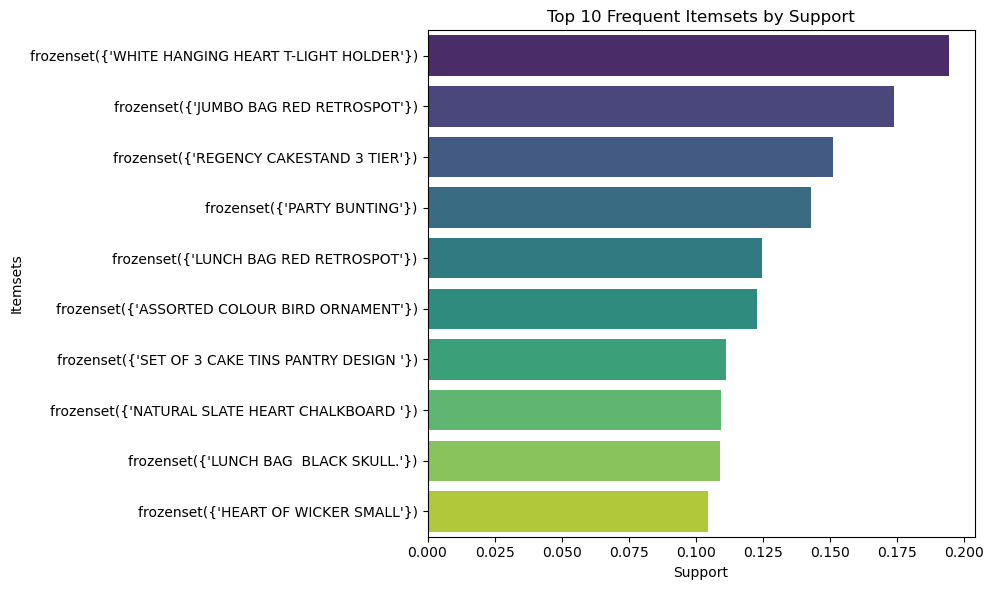

In [21]:
# ---  Visualization: Top 10 Frequent Itemsets ---
top_itemsets = frequent_itemsets.sort_values(by='support', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_itemsets['support'], y=top_itemsets['itemsets'].astype(str), palette='viridis')
plt.title('Top 10 Frequent Itemsets by Support')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.tight_layout()
plt.show()

In [ ]:
## 🌐 Visualize Top 10 Association Rules as a Network Graph
We create a **network graph** where:
- **Nodes represent products**.
- **Directed edges represent association rules** from antecedents to consequents.
- **Edge thickness is proportional to lift** — indicating the strength of the association.

This helps visually reveal interconnected products and how product recommendations can be derived from associations.


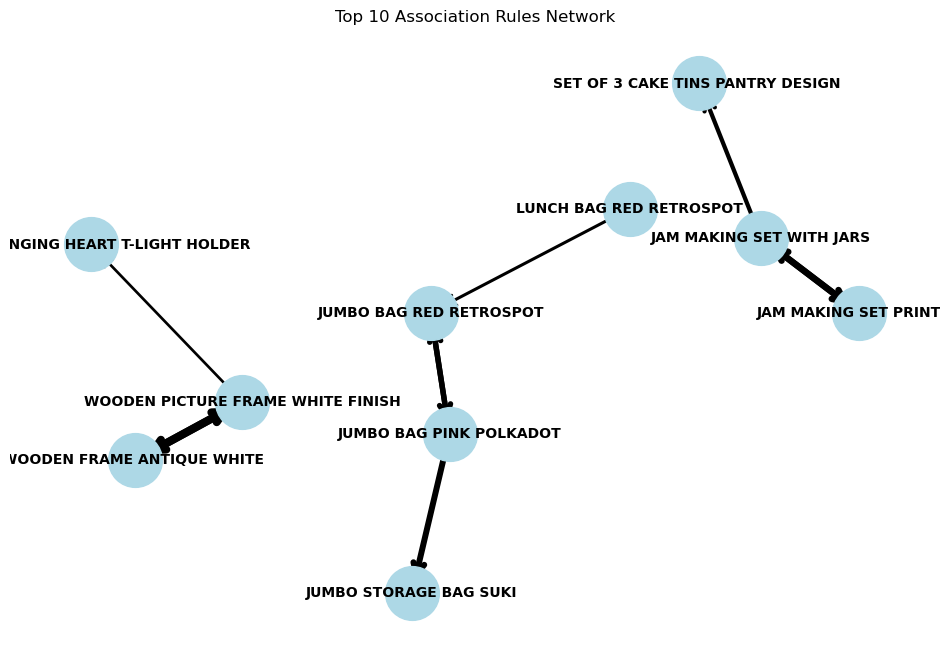

In [22]:
# ---  Network Graph of Top 10 Rules ---
top_rules = rules.head(10)
G = nx.DiGraph()

for _, row in top_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1)
edges = G.edges(data=True)
weights = [edata['weight'] for _, _, edata in edges]

nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=weights, arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title('Top 10 Association Rules Network')
plt.axis('off')
plt.show()